# CoVaR and ΔCoVaR Estimation
This notebook calculates the Conditional Value at Risk (CoVaR) and ΔCoVaR using quantile regression.
The analysis is based on historical log-returns of an individual systemically important bank (MBANK) and a proxy for the overall banking sector ("system"), represented by an index of major Polish banks.
The methodology follows Adrian and Brunnermeier's systemic risk measurement framework.

## 1. Importing Libraries and Preparing Data



In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load price data for mbank and the system index

mbank = pd.read_csv("0_data/mbk_d.csv", index_col=0, header=0, parse_dates=True)
system = pd.read_csv("0_data/wig_banki_d.csv", index_col=0, header=0, parse_dates=True)

# Restricting data up to December 31, 2024
mbank = mbank.loc[:'2024-12-31', 'Zamkniecie']
system = system.loc[:'2024-12-31', 'Zamkniecie']

# Combining price series
prices = pd.concat([mbank, system], axis=1).dropna()
prices.columns = ['mbank', 'system']

# Calculate daily log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Use the last 250 observations
returns = returns[-250:]


## 2. Defining CoVaR and ΔCoVaR Computation
We define a function that estimates CoVaR and ΔCoVaR using quantile regression at a 1% quantile.
The dependent variable is regressed on the independent variable to capture tail dependencies.


In [2]:
def compute_covar_delta_covar(returns, quantile=0.01, dependent='system', independent='mbank'):
    """
    Compute CoVaR and ΔCoVaR using quantile regression.
    
    :param returns: DataFrame containing returns of the bank and system
    :param quantile: Quantile level for CoVaR (e.g., 0.01 for 99% CoVaR)
    :param dependent: Dependent variable name (e.g., 'system')
    :param independent: Independent variable name (e.g., 'mbank')
    :return: Dictionary of results
    """
    returns = returns[[independent, dependent]].dropna()
    X = sm.add_constant(returns[independent])
    y = returns[dependent]
    
    model = sm.QuantReg(y, X)
    result = model.fit(q=quantile)

    alpha = result.params['const']
    beta = result.params[independent]
    
    var_ind = returns[independent].quantile(quantile)
    median_ind = returns[independent].median()
    
    covar = alpha + beta * var_ind
    covar_median = alpha + beta * median_ind
    delta_covar = covar - covar_median

    return {
        'dependent': dependent,
        'independent': independent,
        'alpha': alpha,
        'beta': beta,
        'VaR (1%)': var_ind,
        'CoVaR 99%': covar,
        'CoVaR (median)': covar_median,
        'ΔCoVaR 99%': delta_covar
    }


## 3. CoVaR and ΔCoVaR Estimation
We compute CoVaR and ΔCoVaR twice:
- once for the system conditional on mbank
- once for mbank conditional on the system


In [3]:
if __name__ == "__main__":
    print("=== System conditioned on mbank ===")
    results1 = compute_covar_delta_covar(returns, dependent='system', independent='mbank')
    for key, value in results1.items():
        print(f"{key}: {value:.6f}" if isinstance(value, float) else f"{key}: {value}")

    print("\n=== mbank conditioned on system ===")
    results2 = compute_covar_delta_covar(returns, dependent='mbank', independent='system')
    for key, value in results2.items():
        print(f"{key}: {value:.6f}" if isinstance(value, float) else f"{key}: {value}")


=== System conditioned on mbank ===
dependent: system
independent: mbank
alpha: -0.018307
beta: 0.745309
VaR (1%): -0.049465
CoVaR 99%: -0.055174
CoVaR (median): -0.018997
ΔCoVaR 99%: -0.036177

=== mbank conditioned on system ===
dependent: mbank
independent: system
alpha: -0.025488
beta: 1.139508
VaR (1%): -0.037819
CoVaR 99%: -0.068583
CoVaR (median): -0.024980
ΔCoVaR 99%: -0.043603


## Interpretation of CoVaR and ΔCoVaR Results
The CoVaR analysis examines the systemic risk interdependence between MBANK and the Polish banking sector index ("system").

When MBANK is in distress (at its 1% VaR), the system's CoVaR at the 1% level is -5.52%, compared to its median CoVaR of -1.90%.
The estimated ΔCoVaR (-3.62%) indicates the extent to which MBANK’s distress amplifies the system's losses relative to normal conditions.

Conversely, when the system is in distress, MBANK’s CoVaR at the 1% level is -6.86%, significantly worse than its median CoVaR of -2.50%.
The ΔCoVaR for MBANK (-4.36%) suggests that MBANK is even more sensitive to systemic distress than the system is to MBANK's distress.

Overall, the results highlight that MBANK is both a contributor to systemic risk and highly vulnerable to systemic shocks, with a stronger effect observed when the system is under stress.

## 4. Visualizing Quantile Regression Fit
We plot the scatterplot of returns and the quantile regression line that represents the 1% conditional quantile.
This highlights the systemic impact of mbank's extreme returns on the system.


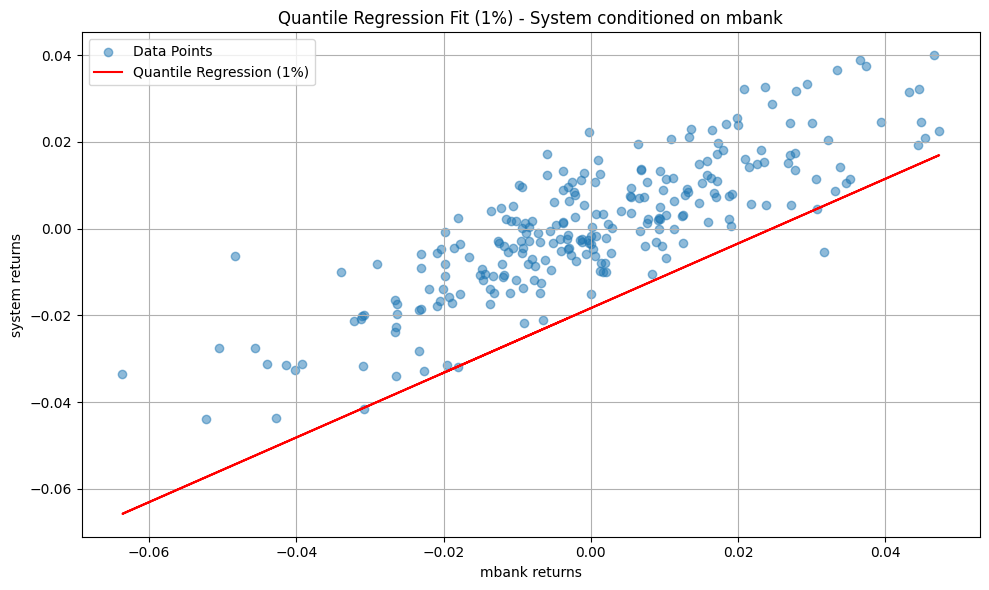

In [4]:
# Quantile regression fit for system on mbank
returns_plot = returns[['mbank', 'system']].dropna()
X_plot = sm.add_constant(returns_plot['mbank'])
model_plot = sm.QuantReg(returns_plot['system'], X_plot).fit(q=0.01)
line_fit = model_plot.params['const'] + model_plot.params['mbank'] * returns_plot['mbank']

plt.figure(figsize=(10, 6))
plt.scatter(returns_plot['mbank'], returns_plot['system'], alpha=0.5, label='Data Points')
plt.plot(returns_plot['mbank'], line_fit, color='red', label='Quantile Regression (1%)')
plt.xlabel('mbank returns')
plt.ylabel('system returns')
plt.title('Quantile Regression Fit (1%) - System conditioned on mbank')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusions
The quantile regression results show a clear positive relationship between MBANK’s extreme negative returns and declines in the broader banking system.
This suggests that MBANK’s distress significantly increases systemic risk, particularly during severe market downturns.

## 5. Return Distributions with VaR and Median
We plot histograms for the mbank and the system returns, highlighting the 1% VaR threshold and the median.


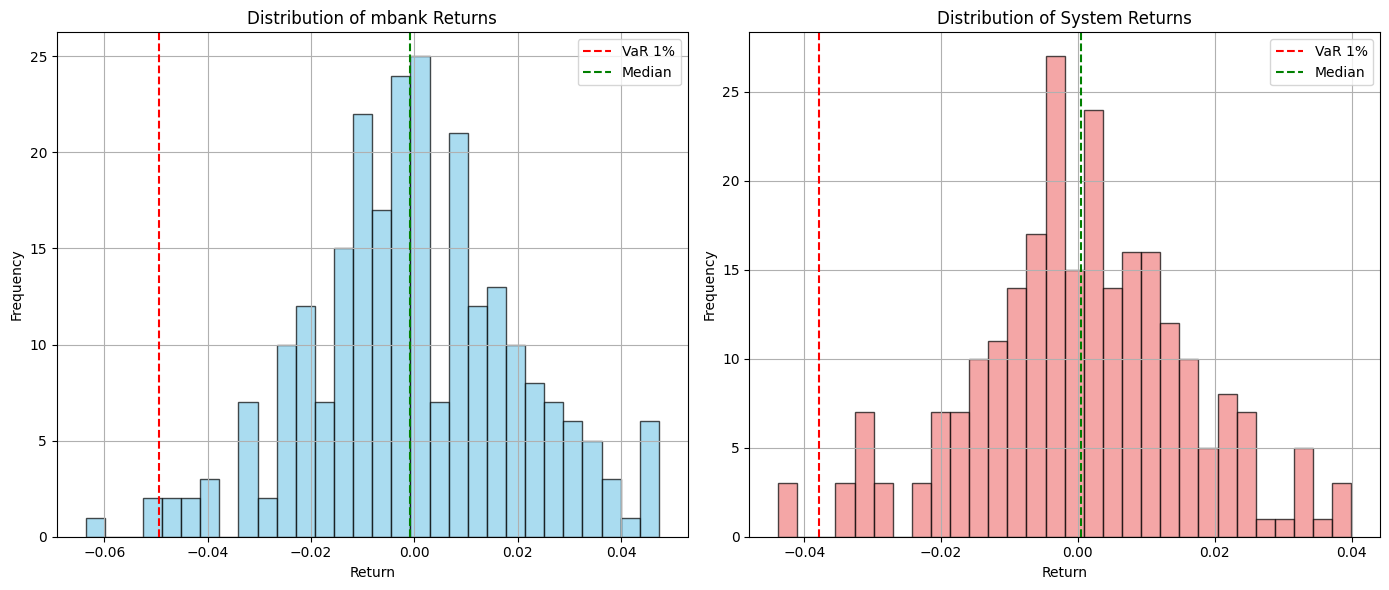

In [5]:
plt.figure(figsize=(14, 6))

# Histogram for mbank
plt.subplot(1, 2, 1)
plt.hist(returns['mbank'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(np.quantile(returns['mbank'], 0.01), color='red', linestyle='--', label='VaR 1%')
plt.axvline(np.median(returns['mbank']), color='green', linestyle='--', label='Median')
plt.title('Distribution of mbank Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Histogram for system
plt.subplot(1, 2, 2)
plt.hist(returns['system'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(np.quantile(returns['system'], 0.01), color='red', linestyle='--', label='VaR 1%')
plt.axvline(np.median(returns['system']), color='green', linestyle='--', label='Median')
plt.title('Distribution of System Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Conclusions
The return distributions for both MBANK and the banking system are slightly skewed to the left, reflecting occasional large negative returns.
The 1% VaR thresholds are visibly more extreme for MBANK, indicating that the individual institution exhibits higher downside risk compared to the broader system.



## 6. Visualizing ΔCoVaR Shift
This plot illustrates the difference between CoVaR under stress and CoVaR under median conditions for the mbank conditioning the system.


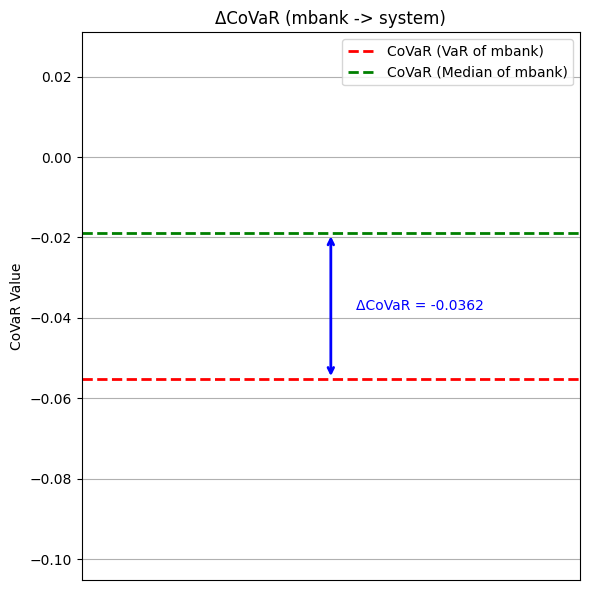

In [6]:
covar = results1['CoVaR 99%']
covar_median = results1['CoVaR (median)']
delta_covar = results1['ΔCoVaR 99%']

plt.figure(figsize=(6, 6))
plt.axhline(covar, color='red', linestyle='--', linewidth=2, label='CoVaR (VaR of mbank)')
plt.axhline(covar_median, color='green', linestyle='--', linewidth=2, label='CoVaR (Median of mbank)')
plt.annotate('', xy=(0.5, covar), xytext=(0.5, covar_median),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
plt.text(0.55, (covar + covar_median) / 2, f'ΔCoVaR = {delta_covar:.4f}', color='blue', va='center')

plt.ylim(min(covar, covar_median) - 0.05, max(covar, covar_median) + 0.05)
plt.xticks([])
plt.title('ΔCoVaR (mbank -> system)')
plt.ylabel('CoVaR Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusions
The ΔCoVaR plot shows that MBANK’s distress leads to a substantial increase in the systemic risk of the banking sector.
The estimated ΔCoVaR of approximately -0.0362 indicates a significant spillover effect from MBANK to the broader system.

## Final Conclusions and Key Insights

In this project, we analyzed the systemic risk interconnections between MBANK, a systemically important institution, and the broader Polish banking sector using the CoVaR (Conditional Value at Risk) and ΔCoVaR methodology.

Key findings are:

    Systemic Impact of MBANK:
    The ΔCoVaR analysis indicates that MBANK's distress leads to a substantial increase in systemic risk. Specifically, MBANK's stress increases the system's losses by approximately 3.62 percentage points compared to normal conditions.

    Asymmetry in Vulnerability:
    While MBANK significantly impacts the system during its own distress events, MBANK itself is even more sensitive to systemic downturns. When the system is under stress, MBANK’s expected losses deteriorate even further, suggesting high vulnerability to sector-wide crises.

    Return Distribution Characteristics:
    Both MBANK and the banking system exhibit left-skewed return distributions, reflecting occasional large negative returns. MBANK shows more extreme downside risk, with its 1% VaR threshold being visibly more severe compared to the system.

    Quantile Regression Insights:
    Quantile regression results confirm a positive relationship between MBANK’s extreme losses and those of the broader system, reinforcing the presence of systemic risk spillovers during market downturns.

Final Interpretation

The CoVaR and ΔCoVaR framework provides strong evidence that MBANK is not only a contributor to systemic risk but also highly exposed to systemic shocks. These findings emphasize the need for close monitoring of such institutions from a systemic risk management perspective.